In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import scirpy as ir
from matplotlib import pyplot as plt, cm as mpl_cm
%matplotlib inline
from cycler import cycler
import celltypist
from celltypist import models

import anndata as ad
from anndata import AnnData
#!pip install psutil
import doubletdetection
sc.settings.verbosity = 2  # verbosity: errors (0), warnings (1), info (2), hints (3)

In [2]:
blood_results_file = 'outputs/blood_adata.h5ad'  # the file that will store the analysis results
skin_results_file = 'outputs/skin_adata.h5ad'  # the file that will store the analysis results
merged_results_file = 'outputs/merged_adata.h5ad'  # the file that will store the analysis results
merged_tcells_results_file = 'outputs/merged_tcells_adata.h5ad'  # the file that will store the analysis results

In [3]:
############################################### Blood #####################################################################

In [4]:
# Load the TCR data
adata_tcr_blood = ir.io.read_10x_vdj('C:/Users/mahim/Desktop/HiWi/VDJ_Blood_P2/all_contig_annotations.json')

# Load the associated transcriptomics data
adata_blood = sc.read_10x_mtx('C:/Users/mahim/Desktop/HiWi/Geneexpr_Matrix_Blood_P2/')

In [5]:
adata_tcr_blood.shape

(435, 0)

In [6]:
adata_blood.shape

(4746, 33538)

In [7]:
#Next, we integrate both the TCR and the transcriptomics data into a single :class:anndata.AnnData object using :func:scirpy.pp.merge_with_ir
ir.pp.merge_with_ir(adata_blood, adata_tcr_blood)

... storing 'feature_types' as categorical


In [8]:
#Now, we can use TCR-related variables together with the gene expression data. Here, we visualize the cells with a detected TCR on the UMAP plot. It is reassuring that the TCRs coincide with the T-cell marker gene CD3.
sc.pp.normalize_total(adata_blood, target_sum=1e4)
sc.pp.log1p(adata_blood)
sc.pp.pca(adata_blood, svd_solver="arpack")
sc.pp.neighbors(adata_blood)

#save plots
sc.tl.umap(adata_blood)
sc.pl.umap(adata_blood, color=["has_ir", "CD3E"], save = "Adata_blood.pdf")

normalizing counts per cell
    finished (0:00:00)
computing PCA
    with n_comps=50
    finished (0:00:12)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:17)
computing UMAP
    finished (0:00:09)


In [9]:
#Doublet detection
clf = doubletdetection.BoostClassifier(
    n_iters=10,
    clustering_algorithm="leiden",
    standard_scaling=True,
    pseudocount=0.1,
    n_jobs=-1,
)
doublets = clf.fit(adata_blood.X).predict(p_thresh=1e-16, voter_thresh=0.5)
doublet_score = clf.doublet_score()

  0%|          | 0/10 [00:00<?, ?it/s]

computing PCA
Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.`
    with n_comps=30
    finished (0:00:02)
computing neighbors
    using 'X_pca' with n_pcs = 30
    finished (0:00:01)
running Leiden clustering
    finished (0:00:00)
computing PCA
Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.`
    with n_comps=30
    finished (0:00:02)
computing neighbors
    using 'X_pca' with n_pcs = 30
    finished (0:00:01)
running Leiden clustering
    finished (0:00:00)
computing PCA
Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.`
    with n_comps=30
    finished (0:00:03)
computing neighbors
    using 'X_pca' with n_pcs = 30
    

In [10]:
adata_blood.obs["doublet"] = doublets
adata_blood.obs["doublet_score"] = doublet_score

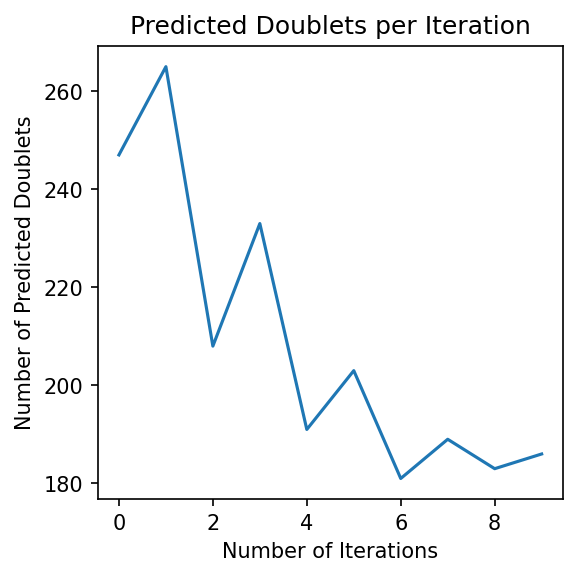

In [12]:
#convergence of doublets calls
%matplotlib inline
f = doubletdetection.plot.convergence(clf, save='convergence_test.pdf', show=True, p_thresh=1e-16, voter_thresh=0.5)

In [13]:
sc.pp.normalize_total(adata_blood)
sc.pp.log1p(adata_blood)
sc.pp.highly_variable_genes(adata_blood)
sc.tl.pca(adata_blood)
sc.pp.neighbors(adata_blood)
sc.tl.umap(adata_blood)

normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:01)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:00)
computing UMAP
    finished (0:00:10)


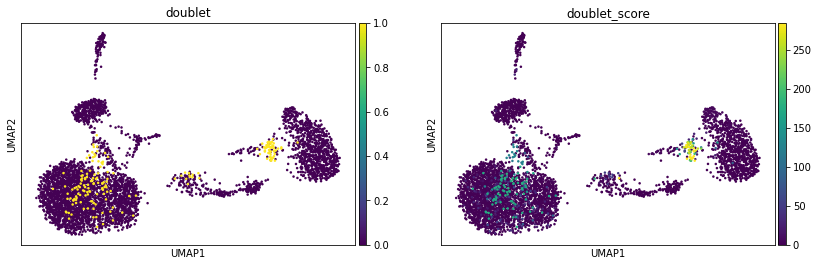

In [14]:
sc.pl.umap(adata_blood, color=["doublet", "doublet_score"], save = "Adata_blood_doublets.pdf")

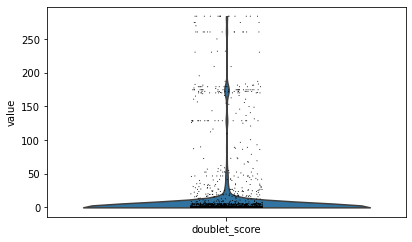

In [15]:
sc.pl.violin(adata_blood, "doublet_score", save = "Adata_blood_doublet_violinplot.pdf")

In [16]:
#adata_blood.obs

#remove all cells where doublet score is >= 150
adata_blood = adata_blood[adata_blood.obs["doublet_score"] < 150]
adata_blood.obs

,is_cell,high_confidence,multi_chain,extra_chains,IR_VJ_1_c_call,IR_VJ_2_c_call,IR_VDJ_1_c_call,IR_VDJ_2_c_call,IR_VJ_1_consensus_count,IR_VJ_2_consensus_count,...,IR_VJ_2_productive,IR_VDJ_1_productive,IR_VDJ_2_productive,IR_VJ_1_v_call,IR_VJ_2_v_call,IR_VDJ_1_v_call,IR_VDJ_2_v_call,has_ir,doublet,doublet_score
AAACCTGAGATCCCAT-1,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,None,None,None,NaN,NaN,NaN,NaN,None,0.0,0.000005
AAACCTGAGCGATCCC-1,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,None,None,None,NaN,NaN,NaN,NaN,None,0.0,0.000003
AAACCTGCACCAGGCT-1,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,None,None,None,NaN,NaN,NaN,NaN,None,0.0,0.000003
AAACCTGCAGGTGCCT-1,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,None,None,None,NaN,NaN,NaN,NaN,None,0.0,0.006397
AAACCTGCATAGACTC-1,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,None,None,None,NaN,NaN,NaN,NaN,None,0.0,0.005781
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCACATGGATGG-1,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,None,None,None,NaN,NaN,NaN,NaN,None,0.0,0.464883
TTTGTCAGTCTCATCC-1,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,None,None,None,NaN,NaN,NaN,NaN,None,0.0,0.178824
TTTGTCAGTGGTAACG-1,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,None,None,None,NaN,NaN,NaN,NaN,None,0.0,0.000003
TTTGTCAGTTGTCTTT-1,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,None,None,None,NaN,NaN,NaN,NaN,None,0.0,0.000001


In [17]:
#Preprocess Transcriptomics data
sc.pp.filter_genes(adata_blood, min_cells=10)
sc.pp.filter_cells(adata_blood, min_genes=100)

filtered out 20605 genes that are detected in less than 10 cells
Trying to set attribute `.var` of view, copying.
filtered out 15 cells that have less than 100 genes expressed


In [18]:
sc.pp.normalize_per_cell(adata_blood, counts_per_cell_after=10000)
sc.pp.log1p(adata_blood)
sc.pp.highly_variable_genes(adata_blood, flavor="cell_ranger", n_top_genes=5000)
sc.tl.pca(adata_blood)
sc.pp.neighbors(adata_blood)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:05)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:00)


running Leiden clustering
    finished (0:00:00)


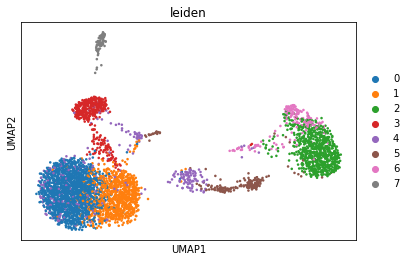

In [19]:
#Clustering the neighborhood graph
sc.tl.leiden(adata_blood)
sc.pl.umap(adata_blood, color=['leiden'],  save = "_Leiden_clustering_Adata_blood.pdf")
adata_blood.write(blood_results_file)

In [20]:
# Enabling `force_update = True` will overwrite existing (old) models.
models.download_models(force_update = True)

📜 Retrieving model list from server https://celltypist.cog.sanger.ac.uk/models/models.json
📚 Total models in list: 12
📂 Storing models in C:\Users\mahim\.celltypist\data\models
💾 Downloading model [1/12]: Immune_All_Low.pkl
💾 Downloading model [2/12]: Immune_All_High.pkl
💾 Downloading model [3/12]: Adult_Mouse_Gut.pkl
💾 Downloading model [4/12]: COVID19_Immune_Landscape.pkl
💾 Downloading model [5/12]: Cells_Fetal_Lung.pkl
💾 Downloading model [6/12]: Cells_Intestinal_Tract.pkl
💾 Downloading model [7/12]: Cells_Lung_Airway.pkl
💾 Downloading model [8/12]: Developing_Mouse_Brain.pkl
💾 Downloading model [9/12]: Healthy_COVID19_PBMC.pkl
💾 Downloading model [10/12]: Human_Lung_Atlas.pkl
💾 Downloading model [11/12]: Nuclei_Lung_Airway.pkl
💾 Downloading model [12/12]: Pan_Fetal_Human.pkl


In [21]:
models.models_path
models.models_description()

👉 Detailed model information can be found at `https://www.celltypist.org/models`


,model,description
0,Immune_All_Low.pkl,immune sub-populations combined from 20 tissue...
1,Immune_All_High.pkl,immune populations combined from 20 tissues of...
2,Adult_Mouse_Gut.pkl,cell types in the adult mouse gut combined fro...
3,COVID19_Immune_Landscape.pkl,immune subtypes from lung and blood of COVID-1...
4,Cells_Fetal_Lung.pkl,cell types from human embryonic and fetal lungs
5,Cells_Intestinal_Tract.pkl,"intestinal cells from fetal, pediatric and adu..."
6,Cells_Lung_Airway.pkl,cell populations from scRNA-seq of five locati...
7,Developing_Mouse_Brain.pkl,cell types from the embryonic mouse brain betw...
8,Healthy_COVID19_PBMC.pkl,peripheral blood mononuclear cell types from h...
9,Human_Lung_Atlas.pkl,integrated Human Lung Cell Atlas (HLCA) combin...


In [22]:
# Indeed, the `model` argument defaults to `Immune_All_Low.pkl`.
model = models.Model.load(model = 'Immune_All_Low.pkl')
model
model.cell_types

array(['Age-associated B cells', 'Alveolar macrophages', 'B cells',
       'CD16+ NK cells', 'CD16- NK cells', 'CD8a/a', 'CD8a/b(entry)',
       'CMP', 'CRTAM+ gamma-delta T cells', 'Classical monocytes',
       'Cycling B cells', 'Cycling DCs', 'Cycling NK cells',
       'Cycling T cells', 'Cycling gamma-delta T cells',
       'Cycling monocytes', 'DC', 'DC precursor', 'DC1', 'DC2', 'DC3',
       'Double-negative thymocytes', 'Double-positive thymocytes', 'ELP',
       'ETP', 'Early MK', 'Early erythroid', 'Early lymphoid/T lymphoid',
       'Endothelial cells', 'Epithelial cells', 'Erythrocytes',
       'Erythrophagocytic macrophages', 'Fibroblasts',
       'Follicular B cells', 'Follicular helper T cells', 'GMP',
       'Germinal center B cells', 'Granulocytes', 'HSC/MPP',
       'Hofbauer cells', 'ILC', 'ILC precursor', 'ILC1', 'ILC2', 'ILC3',
       'Intermediate macrophages', 'Intestinal macrophages',
       'Kidney-resident macrophages', 'Kupffer cells',
       'Large pre-B cell

In [23]:
# Not run; predict cell identities using this loaded model.
#predictions = celltypist.annotate(adata_2000, model = model, majority_voting = True)
# Alternatively, just specify the model name (recommended as this ensures the model is intact every time it is loaded).
adata_blood.X.expm1().sum(axis = 1)

matrix([[ 9999.999],
        [10000.001],
        [ 9999.999],
        ...,
        [ 9999.999],
        [10000.   ],
        [ 9999.998]], dtype=float32)

In [24]:
blood_predictions = celltypist.annotate(adata_blood, model = 'Immune_All_Low.pkl', majority_voting = True)

🔬 Input data has 4603 cells and 12933 genes
🔗 Matching reference genes in the model
🧬 4463 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 5
running Leiden clustering
    finished (0:00:01)
🗳️ Majority voting the predictions
✅ Majority voting done!


In [25]:
blood_predictions.predicted_labels

,predicted_labels,over_clustering,majority_voting
AAACCTGAGATCCCAT-1,NK cells,55,CD16+ NK cells
AAACCTGAGCGATCCC-1,Classical monocytes,7,Classical monocytes
AAACCTGCACCAGGCT-1,CD16+ NK cells,56,CD16- NK cells
AAACCTGCAGGTGCCT-1,CD16- NK cells,49,NK cells
AAACCTGCATAGACTC-1,NK cells,49,NK cells
...,...,...,...
TTTGTCACATGGATGG-1,CD16+ NK cells,53,CD16+ NK cells
TTTGTCAGTCTCATCC-1,CD16+ NK cells,55,CD16+ NK cells
TTTGTCAGTGGTAACG-1,Classical monocytes,4,Classical monocytes
TTTGTCAGTTGTCTTT-1,CD16+ NK cells,65,CD16+ NK cells


In [26]:
# Get an `AnnData` with predicted labels embedded into the cell metadata columns.
adata_blood = blood_predictions.to_adata()
adata_blood.obs

,is_cell,high_confidence,multi_chain,extra_chains,IR_VJ_1_c_call,IR_VJ_2_c_call,IR_VDJ_1_c_call,IR_VDJ_2_c_call,IR_VJ_1_consensus_count,IR_VJ_2_consensus_count,...,has_ir,doublet,doublet_score,n_genes,n_counts,leiden,predicted_labels,over_clustering,majority_voting,conf_score
AAACCTGAGATCCCAT-1,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,None,0.0,0.000005,988,1167.923828,0,NK cells,55,CD16+ NK cells,0.383117
AAACCTGAGCGATCCC-1,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,None,0.0,0.000003,1449,1340.021729,2,Classical monocytes,7,Classical monocytes,0.998923
AAACCTGCACCAGGCT-1,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,None,0.0,0.000003,1118,1232.134766,0,CD16+ NK cells,56,CD16- NK cells,0.993977
AAACCTGCAGGTGCCT-1,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,None,0.0,0.006397,1234,1275.848022,0,CD16- NK cells,49,NK cells,0.614845
AAACCTGCATAGACTC-1,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,None,0.0,0.005781,1285,1295.736694,0,NK cells,49,NK cells,0.049980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCACATGGATGG-1,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,None,0.0,0.464883,1593,1397.392212,0,CD16+ NK cells,53,CD16+ NK cells,0.159665
TTTGTCAGTCTCATCC-1,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,None,0.0,0.178824,1389,1331.969849,0,CD16+ NK cells,55,CD16+ NK cells,0.714418
TTTGTCAGTGGTAACG-1,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,None,0.0,0.000003,1554,1374.368774,2,Classical monocytes,4,Classical monocytes,0.999780
TTTGTCAGTTGTCTTT-1,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,None,0.0,0.000001,1143,1236.581787,0,CD16+ NK cells,65,CD16+ NK cells,0.099127


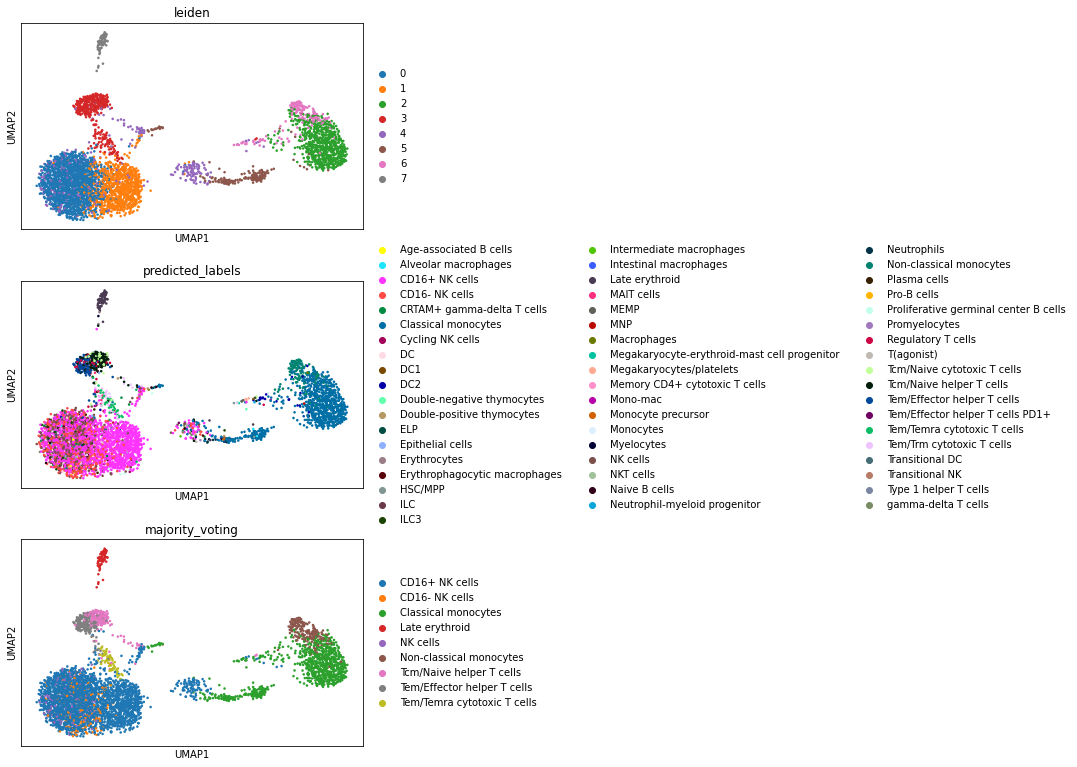

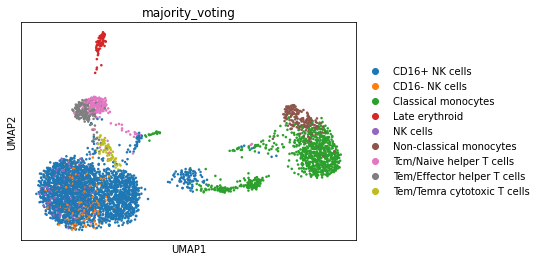

In [27]:
sc.pl.umap(adata_blood, color = ['leiden', 'predicted_labels', 'majority_voting'], ncols=1,
    wspace=0.1)
sc.pl.umap(adata_blood, color = ['majority_voting'],  save = "_celltype_annotation_Adata_blood.pdf")

... storing 'receptor_type' as categorical
... storing 'receptor_subtype' as categorical
... storing 'chain_pairing' as categorical


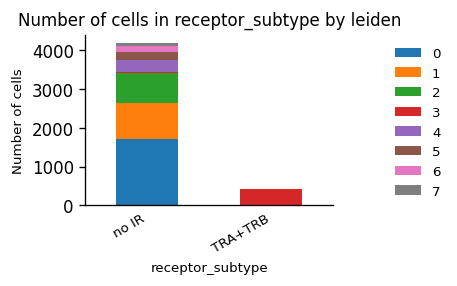

In [31]:
#Clonotype analysis
ir.tl.chain_qc(adata_blood)
#ax = ir.pl.group_abundance(adata_blood, groupby="receptor_subtype", target_col="majority_voting")
#ax.figure.savefig("figures/Group_abundance_by_celltype.pdf")
ax = ir.pl.group_abundance(adata_blood, groupby="receptor_subtype", target_col="leiden")
ax.figure.savefig("figures/Group_abundance_by_leiden.pdf")


In [61]:
adata_blood.obs['source'] = 'Blood'
adata_blood.obs
adata_blood.write("./output-files/adata_blood.rds")

... storing 'source' as categorical


In [32]:
############################################################ Skin ##########################################################

In [33]:
# Load the TCR data
adata_tcr_skin = ir.io.read_10x_vdj('C:/Users/mahim/Desktop/HiWi/VDJ_Skin_P2/all_contig_annotations.json')

# Load the associated transcriptomics data
adata_skin = sc.read_10x_mtx('C:/Users/mahim/Desktop/HiWi/Geneexpr_Matrix_Skin_P2/')

In [34]:
adata_tcr_skin.shape

(935, 0)

In [35]:
adata_skin.shape

(3325, 33538)

In [36]:
#Next, we integrate both the TCR and the transcriptomics data into a single :class:anndata.AnnData object using :func:scirpy.pp.merge_with_ir
ir.pp.merge_with_ir(adata_skin, adata_tcr_skin)

... storing 'feature_types' as categorical


normalizing counts per cell
    finished (0:00:00)
computing PCA
    with n_comps=50
    finished (0:00:06)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:00)
computing UMAP
    finished (0:00:07)


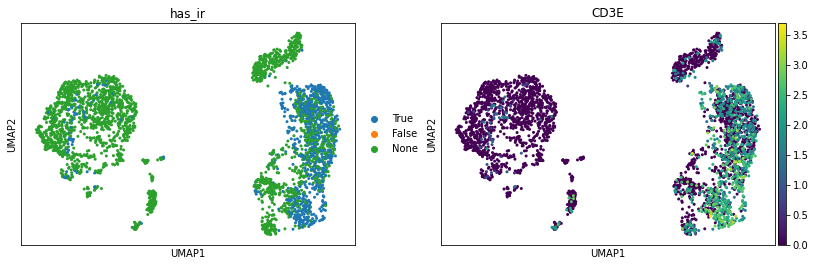

In [37]:
#Now, we can use TCR-related variables together with the gene expression data. Here, we visualize the cells with a detected TCR on the UMAP plot. It is reassuring that the TCRs coincide with the T-cell marker gene CD3.
sc.pp.normalize_total(adata_skin, target_sum=1e4)
sc.pp.log1p(adata_skin)
sc.pp.pca(adata_skin, svd_solver="arpack")
sc.pp.neighbors(adata_skin)

#save plots
sc.tl.umap(adata_skin)
sc.pl.umap(adata_skin, color=["has_ir", "CD3E"], save = "_Adata_skin.pdf")

In [38]:
#Doublet detection
clf = doubletdetection.BoostClassifier(
    n_iters=10,
    clustering_algorithm="leiden",
    standard_scaling=True,
    pseudocount=0.1,
    n_jobs=-1,
)
doublets = clf.fit(adata_skin.X).predict(p_thresh=1e-16, voter_thresh=0.5)
doublet_score = clf.doublet_score()

  0%|          | 0/10 [00:00<?, ?it/s]

computing PCA
Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.`
    with n_comps=30
    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 30
    finished (0:00:00)
running Leiden clustering
    finished (0:00:00)
computing PCA
Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.`
    with n_comps=30
    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 30
    finished (0:00:00)
running Leiden clustering
    finished (0:00:00)
computing PCA
Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.`
    with n_comps=30
    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 30
    

In [39]:
adata_skin.obs["doublet"] = doublets
adata_skin.obs["doublet_score"] = doublet_score

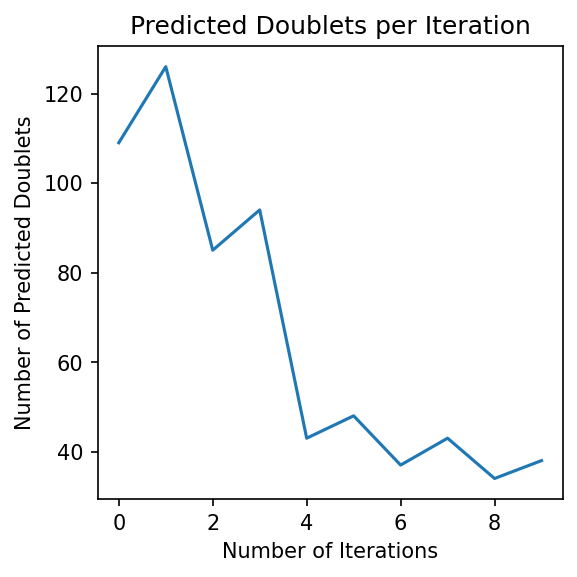

In [40]:
#convergence of doublets calls
f = doubletdetection.plot.convergence(clf, save='convergence_test.pdf', show=True, p_thresh=1e-16, voter_thresh=0.5)

In [41]:
sc.pp.normalize_total(adata_skin)
sc.pp.log1p(adata_skin)
sc.pp.highly_variable_genes(adata_skin)
sc.tl.pca(adata_skin)
sc.pp.neighbors(adata_skin)
sc.tl.umap(adata_skin)

normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:00)
computing UMAP
    finished (0:00:07)


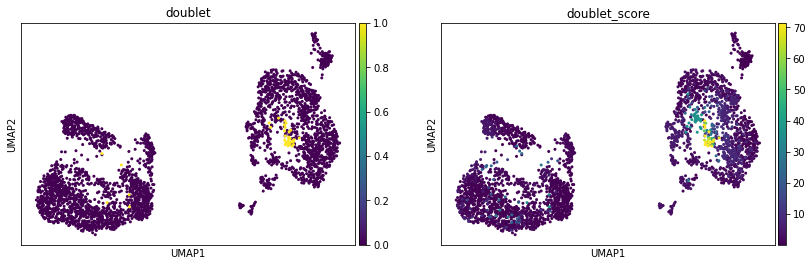

In [42]:
sc.pl.umap(adata_skin, color=["doublet", "doublet_score"], save = "Adata_skin_doublets.pdf")

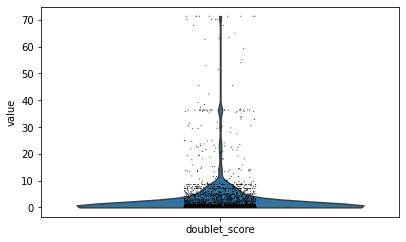

In [43]:
sc.pl.violin(adata_skin, "doublet_score", save = "Adata_skin_doublet_violinplot.pdf")

In [44]:
#remove all cells where doublet score is >= 150
adata_skin = adata_skin[adata_skin.obs["doublet_score"] < 40]
adata_skin.obs

,is_cell,high_confidence,multi_chain,extra_chains,IR_VJ_1_c_call,IR_VJ_2_c_call,IR_VDJ_1_c_call,IR_VDJ_2_c_call,IR_VJ_1_consensus_count,IR_VJ_2_consensus_count,...,IR_VJ_2_productive,IR_VDJ_1_productive,IR_VDJ_2_productive,IR_VJ_1_v_call,IR_VJ_2_v_call,IR_VDJ_1_v_call,IR_VDJ_2_v_call,has_ir,doublet,doublet_score
AAACCTGAGAGCAATT-1,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,None,None,None,NaN,NaN,NaN,NaN,None,0.0,0.064706
AAACCTGCATCGATTG-1,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,None,None,None,NaN,NaN,NaN,NaN,None,0.0,2.532758
AAACCTGGTTAAGTAG-1,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,None,None,None,NaN,NaN,NaN,NaN,None,0.0,0.107017
AAACCTGTCAGTTGAC-1,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,None,None,None,NaN,NaN,NaN,NaN,None,0.0,0.037583
AAACCTGTCCGCGCAA-1,True,True,False,"[{""c_call"": ""TRBC2"", ""consensus_count"": 15424,...",TRAC,NaN,TRBC1,NaN,4116.0,NaN,...,None,True,None,TRAV23/DV6,NaN,TRBV4-3,NaN,True,0.0,3.810621
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCAAGGTGATAT-1,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,None,None,None,NaN,NaN,NaN,NaN,None,0.0,0.000480
TTTGTCACAGATCGGA-1,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,None,None,None,NaN,NaN,NaN,NaN,None,0.0,0.601201
TTTGTCACAGTCGTGC-1,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,None,None,None,NaN,NaN,NaN,NaN,None,0.0,0.003062
TTTGTCAGTCCTGCTT-1,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,None,None,None,NaN,NaN,NaN,NaN,None,0.0,3.295971


In [45]:
#Preprocess Transcriptomics data
sc.pp.filter_genes(adata_skin, min_cells=10)
sc.pp.filter_cells(adata_skin, min_genes=100)

filtered out 20124 genes that are detected in less than 10 cells
Trying to set attribute `.var` of view, copying.
filtered out 3 cells that have less than 100 genes expressed


In [46]:
sc.pp.normalize_per_cell(adata_skin, counts_per_cell_after=10000)
sc.pp.log1p(adata_skin)
sc.pp.highly_variable_genes(adata_skin, flavor="cell_ranger", n_top_genes=5000)
sc.tl.pca(adata_skin)
sc.pp.neighbors(adata_skin)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:02)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:00)


running Leiden clustering
    finished (0:00:00)


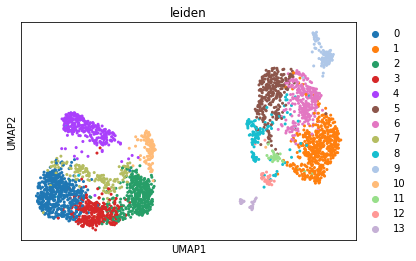

In [47]:
#Clustering the neighborhood graph
sc.tl.leiden(adata_skin)
sc.pl.umap(adata_skin, color=['leiden'],  save = "_Leiden_clustering_Adata_skin.pdf")
adata_skin.write(skin_results_file)

In [48]:
#Celltype annotation
# Indeed, the `model` argument defaults to `Immune_All_Low.pkl`.
model = models.Model.load(model = 'Immune_All_Low.pkl')
model
model.cell_types

array(['Age-associated B cells', 'Alveolar macrophages', 'B cells',
       'CD16+ NK cells', 'CD16- NK cells', 'CD8a/a', 'CD8a/b(entry)',
       'CMP', 'CRTAM+ gamma-delta T cells', 'Classical monocytes',
       'Cycling B cells', 'Cycling DCs', 'Cycling NK cells',
       'Cycling T cells', 'Cycling gamma-delta T cells',
       'Cycling monocytes', 'DC', 'DC precursor', 'DC1', 'DC2', 'DC3',
       'Double-negative thymocytes', 'Double-positive thymocytes', 'ELP',
       'ETP', 'Early MK', 'Early erythroid', 'Early lymphoid/T lymphoid',
       'Endothelial cells', 'Epithelial cells', 'Erythrocytes',
       'Erythrophagocytic macrophages', 'Fibroblasts',
       'Follicular B cells', 'Follicular helper T cells', 'GMP',
       'Germinal center B cells', 'Granulocytes', 'HSC/MPP',
       'Hofbauer cells', 'ILC', 'ILC precursor', 'ILC1', 'ILC2', 'ILC3',
       'Intermediate macrophages', 'Intestinal macrophages',
       'Kidney-resident macrophages', 'Kupffer cells',
       'Large pre-B cell

In [49]:
# Not run; predict cell identities using this loaded model.
#predictions = celltypist.annotate(adata_2000, model = model, majority_voting = True)
# Alternatively, just specify the model name (recommended as this ensures the model is intact every time it is loaded).
adata_skin.X.expm1().sum(axis = 1)

matrix([[10000.   ],
        [10000.   ],
        [10000.   ],
        ...,
        [10000.001],
        [ 9999.999],
        [ 9999.999]], dtype=float32)

In [50]:
skin_predictions = celltypist.annotate(adata_skin, model = 'Immune_All_Low.pkl', majority_voting = True)

🔬 Input data has 3294 cells and 13414 genes
🔗 Matching reference genes in the model
🧬 4806 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 5
running Leiden clustering
    finished (0:00:00)
🗳️ Majority voting the predictions
✅ Majority voting done!


In [51]:
skin_predictions.predicted_labels

,predicted_labels,over_clustering,majority_voting
AAACCTGAGAGCAATT-1,Intermediate macrophages,10,Intermediate macrophages
AAACCTGCATCGATTG-1,DC,29,Intermediate macrophages
AAACCTGGTTAAGTAG-1,CD16- NK cells,11,CD16- NK cells
AAACCTGTCAGTTGAC-1,Type 1 helper T cells,2,Type 1 helper T cells
AAACCTGTCCGCGCAA-1,Regulatory T cells,38,Regulatory T cells
...,...,...,...
TTTGTCAAGGTGATAT-1,Type 1 helper T cells,2,Type 1 helper T cells
TTTGTCACAGATCGGA-1,Intermediate macrophages,9,Intermediate macrophages
TTTGTCACAGTCGTGC-1,Tem/Trm cytotoxic T cells,19,Regulatory T cells
TTTGTCAGTCCTGCTT-1,Fibroblasts,37,Fibroblasts


In [52]:
# Get an `AnnData` with predicted labels embedded into the cell metadata columns.
adata_skin = skin_predictions.to_adata()
adata_skin.obs

,is_cell,high_confidence,multi_chain,extra_chains,IR_VJ_1_c_call,IR_VJ_2_c_call,IR_VDJ_1_c_call,IR_VDJ_2_c_call,IR_VJ_1_consensus_count,IR_VJ_2_consensus_count,...,has_ir,doublet,doublet_score,n_genes,n_counts,leiden,predicted_labels,over_clustering,majority_voting,conf_score
AAACCTGAGAGCAATT-1,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,None,0.0,0.064706,1328,1143.986450,1,Intermediate macrophages,10,Intermediate macrophages,0.380062
AAACCTGCATCGATTG-1,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,None,0.0,2.532758,1667,1210.531006,1,DC,29,Intermediate macrophages,0.018991
AAACCTGGTTAAGTAG-1,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,None,0.0,0.107017,738,909.529053,4,CD16- NK cells,11,CD16- NK cells,0.126060
AAACCTGTCAGTTGAC-1,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,None,0.0,0.037583,556,815.349854,2,Type 1 helper T cells,2,Type 1 helper T cells,0.062691
AAACCTGTCCGCGCAA-1,True,True,False,"[{""c_call"": ""TRBC2"", ""consensus_count"": 15424,...",TRAC,NaN,TRBC1,NaN,4116.0,NaN,...,True,0.0,3.810621,1784,1250.768433,7,Regulatory T cells,38,Regulatory T cells,0.710742
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCAAGGTGATAT-1,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,None,0.0,0.000480,773,935.316101,2,Type 1 helper T cells,2,Type 1 helper T cells,0.084731
TTTGTCACAGATCGGA-1,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,None,0.0,0.601201,1388,1142.325806,6,Intermediate macrophages,9,Intermediate macrophages,0.244289
TTTGTCACAGTCGTGC-1,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,None,0.0,0.003062,625,862.006897,3,Tem/Trm cytotoxic T cells,19,Regulatory T cells,0.968253
TTTGTCAGTCCTGCTT-1,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,None,0.0,3.295971,1852,1240.020508,12,Fibroblasts,37,Fibroblasts,0.999998


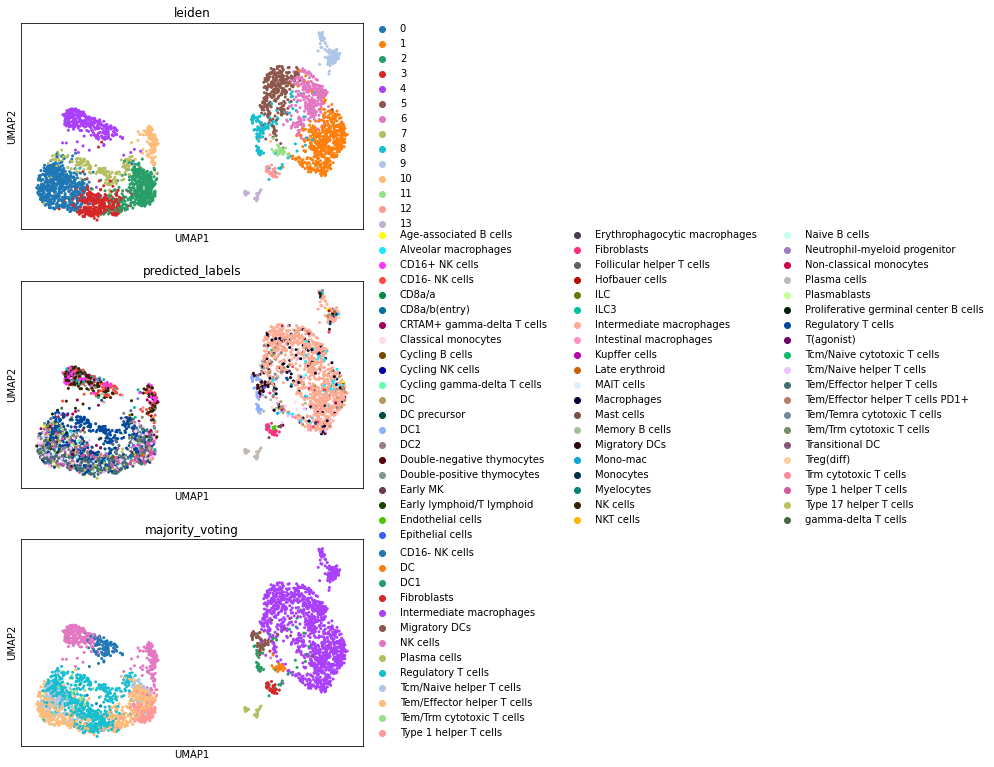

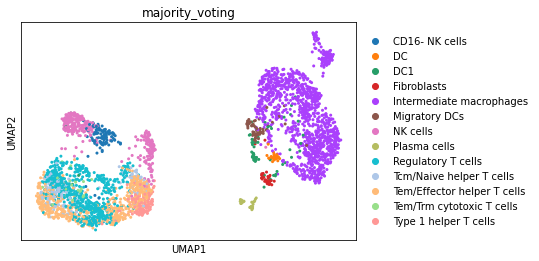

In [53]:
sc.pl.umap(adata_skin, color = ['leiden', 'predicted_labels', 'majority_voting'], ncols=1,
    wspace=0.1)
sc.pl.umap(adata_skin, color = ['majority_voting'],  save = "_celltype_annotation_Adata_skin.pdf")

... storing 'receptor_type' as categorical
... storing 'receptor_subtype' as categorical
... storing 'chain_pairing' as categorical


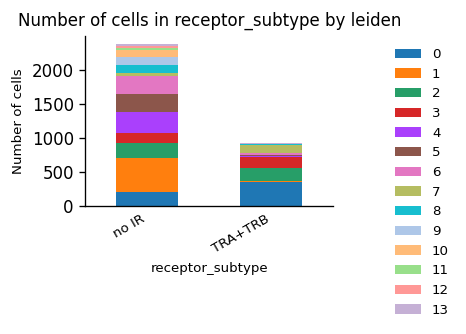

In [63]:
#Clonotype analysis
ir.tl.chain_qc(adata_skin)
#ax = ir.pl.group_abundance(adata_skin, groupby="receptor_subtype", target_col="majority_voting")
#ax.figure.savefig("figures/Group_abundance_by_celltype_skin.pdf")
ax = ir.pl.group_abundance(adata_skin, groupby="receptor_subtype", target_col="leiden")
ax.figure.savefig("figures/Group_abundance_by_leiden_skin.pdf")

In [60]:
adata_skin.obs['source'] = 'Skin'
adata_skin.obs
adata_skin.write("./output-files/adata_skin.rds")

... storing 'source' as categorical


In [64]:
############################################## Merged skin and blood #######################################################

In [65]:
adata_blood.var_names_make_unique()
adata_skin.var_names_make_unique()

In [66]:
#Concatenate data skin and blood
adata = ad.concat([adata_blood, adata_skin], join="outer", index_unique="_")

In [67]:
#Preprocess Transcriptomics data
sc.pp.filter_genes(adata, min_cells=10)
sc.pp.filter_cells(adata, min_genes=100)

filtered out 1 genes that are detected in less than 10 cells


In [68]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=10000)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, flavor="cell_ranger", n_top_genes=5000)
sc.tl.pca(adata)
sc.pp.neighbors(adata)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:02)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:01)


running Leiden clustering
    finished (0:00:00)
... storing 'extra_chains' as categorical
... storing 'IR_VDJ_2_d_call' as categorical
... storing 'IR_VJ_2_j_call' as categorical
... storing 'IR_VDJ_2_j_call' as categorical
... storing 'IR_VJ_1_junction' as categorical
... storing 'IR_VJ_2_junction' as categorical
... storing 'IR_VDJ_1_junction' as categorical
... storing 'IR_VDJ_2_junction' as categorical
... storing 'IR_VJ_1_junction_aa' as categorical
... storing 'IR_VJ_2_junction_aa' as categorical
... storing 'IR_VDJ_1_junction_aa' as categorical
... storing 'IR_VDJ_2_junction_aa' as categorical
... storing 'IR_VJ_1_v_call' as categorical
... storing 'IR_VJ_2_v_call' as categorical
... storing 'IR_VDJ_1_v_call' as categorical
... storing 'IR_VDJ_2_v_call' as categorical
... storing 'predicted_labels' as categorical
... storing 'over_clustering' as categorical
... storing 'majority_voting' as categorical
... storing 'chain_pairing' as categorical
... storing 'source' as categorica

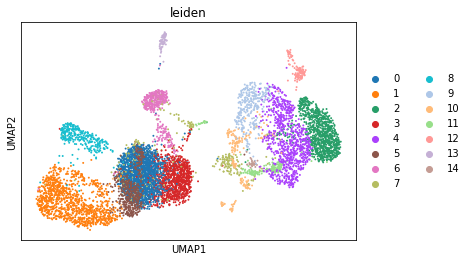

In [69]:
#Clustering the neighborhood graph
sc.tl.leiden(adata)
sc.pl.umap(adata, color=['leiden'],  save = "_Leiden_clustering_Adata_merged.pdf")
#adata.write(merged_results_file)

computing UMAP
    finished (0:00:14)


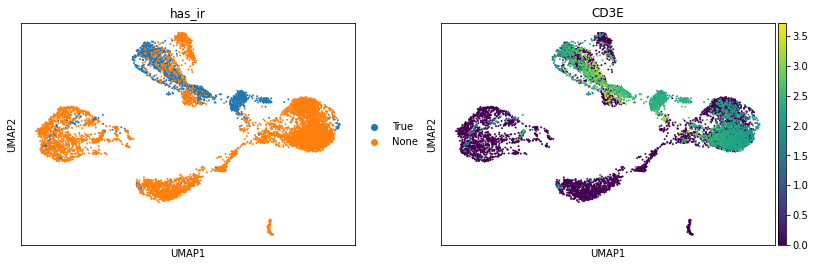

In [70]:
sc.tl.umap(adata)
sc.pl.umap(adata, color=["has_ir", "CD3E"], save = "_Adata_merged.pdf")

In [71]:
#save object
adata.write("./output-files/merged_adata.rds")
adata.obs

,is_cell,high_confidence,multi_chain,extra_chains,IR_VJ_1_c_call,IR_VJ_2_c_call,IR_VDJ_1_c_call,IR_VDJ_2_c_call,IR_VJ_1_consensus_count,IR_VJ_2_consensus_count,...,n_counts,leiden,predicted_labels,over_clustering,majority_voting,conf_score,receptor_type,receptor_subtype,chain_pairing,source
AAACCTGAGATCCCAT-1_0,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2369.533936,0,NK cells,55,CD16+ NK cells,0.383117,no IR,no IR,no IR,Blood
AAACCTGAGCGATCCC-1_0,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2968.891846,2,Classical monocytes,7,Classical monocytes,0.998923,no IR,no IR,no IR,Blood
AAACCTGCACCAGGCT-1_0,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2557.554688,0,CD16+ NK cells,56,CD16- NK cells,0.993977,no IR,no IR,no IR,Blood
AAACCTGCAGGTGCCT-1_0,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2710.489502,0,CD16- NK cells,49,NK cells,0.614845,no IR,no IR,no IR,Blood
AAACCTGCATAGACTC-1_0,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2775.773682,0,NK cells,49,NK cells,0.049980,no IR,no IR,no IR,Blood
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCAAGGTGATAT-1_1,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2028.859131,5,Type 1 helper T cells,2,Type 1 helper T cells,0.084731,no IR,no IR,no IR,Skin
TTTGTCACAGATCGGA-1_1,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2879.185303,9,Intermediate macrophages,9,Intermediate macrophages,0.244289,no IR,no IR,no IR,Skin
TTTGTCACAGTCGTGC-1_1,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1768.378906,1,Tem/Trm cytotoxic T cells,19,Regulatory T cells,0.968253,no IR,no IR,no IR,Skin
TTTGTCAGTCCTGCTT-1_1,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3380.199219,10,Fibroblasts,37,Fibroblasts,0.999998,no IR,no IR,no IR,Skin


In [72]:
#Extract tcells into seperate object
tcells = adata[adata.obs["receptor_type"] == "TCR"]
Tcells_names = ["Regulatory T cells", "Tcm/Naive helper T cells", "Tem/Effector helper T cells", "Tem/Temra cytotoxic T cells", "Tem/Trm cytotoxic T cells"]
tcells = tcells[tcells.obs["majority_voting"].isin(Tcells_names)]
tcells.obs

,is_cell,high_confidence,multi_chain,extra_chains,IR_VJ_1_c_call,IR_VJ_2_c_call,IR_VDJ_1_c_call,IR_VDJ_2_c_call,IR_VJ_1_consensus_count,IR_VJ_2_consensus_count,...,n_counts,leiden,predicted_labels,over_clustering,majority_voting,conf_score,receptor_type,receptor_subtype,chain_pairing,source
AAACCTGTCATTTGGG-1_0,True,True,False,[],TRAC,NaN,TRBC2,NaN,4038.0,NaN,...,2921.043213,6,Tcm/Naive helper T cells,5,Tcm/Naive helper T cells,0.978962,TCR,TRA+TRB,single pair,Blood
AAAGCAATCGTCCAGG-1_0,True,True,False,"[{""c_call"": ""TRAC"", ""consensus_count"": 10982, ...",TRAC,NaN,TRBC2,NaN,12494.0,NaN,...,2752.000000,6,Tcm/Naive cytotoxic T cells,5,Tcm/Naive helper T cells,0.959469,TCR,TRA+TRB,single pair,Blood
AAATGCCCACGAGAGT-1_0,True,True,False,"[{""c_call"": ""TRAC"", ""consensus_count"": 15034, ...",NaN,NaN,TRBC1,NaN,NaN,NaN,...,2748.104248,6,Tcm/Naive helper T cells,5,Tcm/Naive helper T cells,0.992768,TCR,TRA+TRB,orphan VDJ,Blood
AACCATGAGTCGAGTG-1_0,True,True,False,"[{""c_call"": ""TRBC1"", ""consensus_count"": 22558,...",TRAC,NaN,TRBC1,NaN,18562.0,NaN,...,2792.464111,6,Tcm/Naive helper T cells,5,Tcm/Naive helper T cells,0.968854,TCR,TRA+TRB,single pair,Blood
AACGTTGGTTAGTGGG-1_0,True,True,False,"[{""c_call"": ""TRAC"", ""consensus_count"": 23168, ...",TRAC,NaN,TRBC1,NaN,24530.0,NaN,...,2849.823242,6,Tcm/Naive cytotoxic T cells,5,Tcm/Naive helper T cells,0.982709,TCR,TRA+TRB,single pair,Blood
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGCGCCACAAGCCC-1_1,True,True,False,[],NaN,NaN,TRBC1,NaN,NaN,NaN,...,2027.901855,1,Regulatory T cells,40,Tem/Trm cytotoxic T cells,0.786746,TCR,TRA+TRB,orphan VDJ,Skin
TTTGCGCGTCGCGGTT-1_1,True,True,False,"[{""c_call"": null, ""consensus_count"": 1328, ""d_...",TRAC,NaN,TRBC2,NaN,3358.0,NaN,...,1785.012085,1,Regulatory T cells,5,Tcm/Naive helper T cells,0.686506,TCR,TRA+TRB,single pair,Skin
TTTGCGCTCAAAGACA-1_1,True,True,False,"[{""c_call"": ""TRBC1"", ""consensus_count"": 21622,...",NaN,NaN,TRBC2,NaN,NaN,NaN,...,2066.765381,1,Double-positive thymocytes,40,Tem/Trm cytotoxic T cells,0.272056,TCR,TRA+TRB,orphan VDJ,Skin
TTTGGTTAGAGTCGGT-1_1,True,True,False,[],TRAC,NaN,TRBC1,NaN,21848.0,NaN,...,1941.974487,1,Type 1 helper T cells,5,Tcm/Naive helper T cells,0.497633,TCR,TRA+TRB,single pair,Skin


running Leiden clustering
Trying to set attribute `.obs` of view, copying.
    finished (0:00:00)


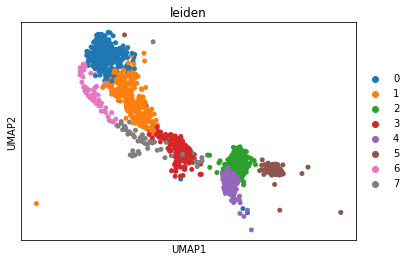

In [73]:
#Clustering the neighborhood graph
sc.tl.leiden(tcells)
sc.pl.umap(tcells, color=['leiden'],  save = "_Leiden_clustering_Adata_merged_tcells.pdf")

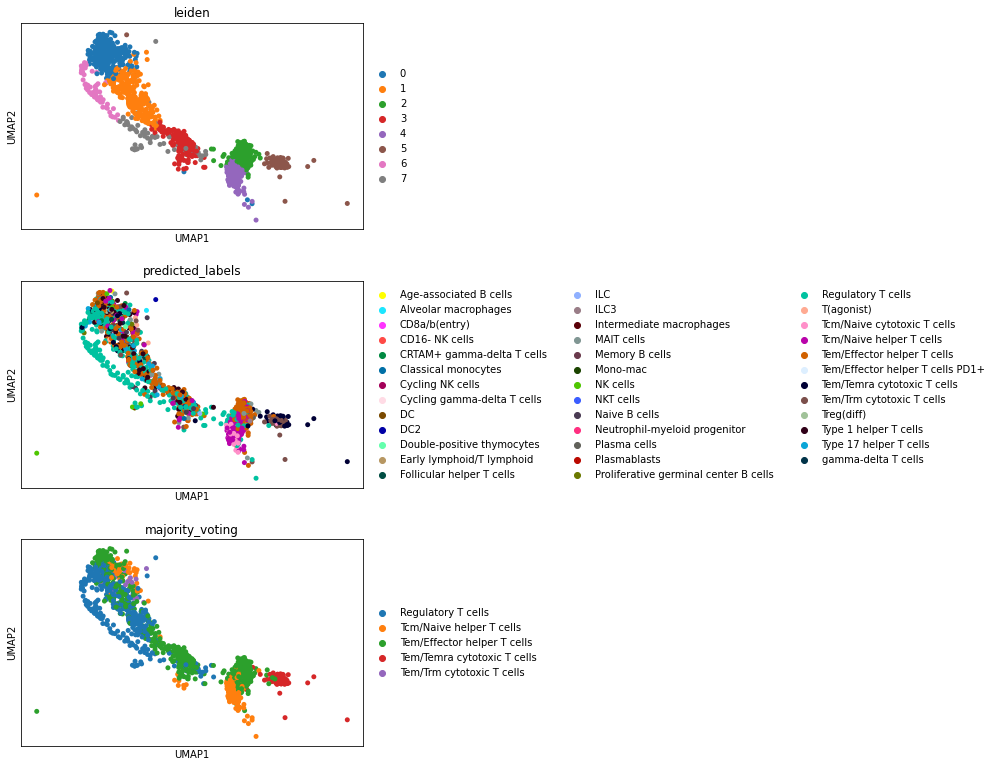

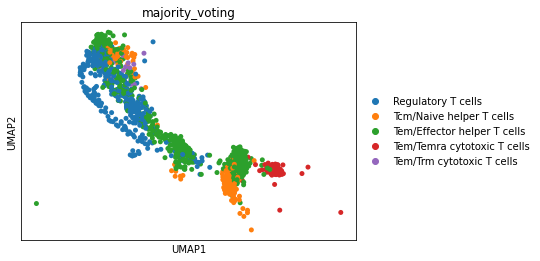

In [74]:
sc.pl.umap(tcells, color = ['leiden', 'predicted_labels', 'majority_voting'], ncols=1,
    wspace=0.1)
sc.pl.umap(tcells, color = ['majority_voting'],  save = "_celltype_annotation_Adata_tcells_merged.pdf")

In [75]:
#save object
tcells.write(./output-files/"merged_tcells_only.rds")
tcells.obs

,is_cell,high_confidence,multi_chain,extra_chains,IR_VJ_1_c_call,IR_VJ_2_c_call,IR_VDJ_1_c_call,IR_VDJ_2_c_call,IR_VJ_1_consensus_count,IR_VJ_2_consensus_count,...,n_counts,leiden,predicted_labels,over_clustering,majority_voting,conf_score,receptor_type,receptor_subtype,chain_pairing,source
AAACCTGTCATTTGGG-1_0,True,True,False,[],TRAC,NaN,TRBC2,NaN,4038.0,NaN,...,2921.043213,4,Tcm/Naive helper T cells,5,Tcm/Naive helper T cells,0.978962,TCR,TRA+TRB,single pair,Blood
AAAGCAATCGTCCAGG-1_0,True,True,False,"[{""c_call"": ""TRAC"", ""consensus_count"": 10982, ...",TRAC,NaN,TRBC2,NaN,12494.0,NaN,...,2752.000000,4,Tcm/Naive cytotoxic T cells,5,Tcm/Naive helper T cells,0.959469,TCR,TRA+TRB,single pair,Blood
AAATGCCCACGAGAGT-1_0,True,True,False,"[{""c_call"": ""TRAC"", ""consensus_count"": 15034, ...",NaN,NaN,TRBC1,NaN,NaN,NaN,...,2748.104248,2,Tcm/Naive helper T cells,5,Tcm/Naive helper T cells,0.992768,TCR,TRA+TRB,orphan VDJ,Blood
AACCATGAGTCGAGTG-1_0,True,True,False,"[{""c_call"": ""TRBC1"", ""consensus_count"": 22558,...",TRAC,NaN,TRBC1,NaN,18562.0,NaN,...,2792.464111,4,Tcm/Naive helper T cells,5,Tcm/Naive helper T cells,0.968854,TCR,TRA+TRB,single pair,Blood
AACGTTGGTTAGTGGG-1_0,True,True,False,"[{""c_call"": ""TRAC"", ""consensus_count"": 23168, ...",TRAC,NaN,TRBC1,NaN,24530.0,NaN,...,2849.823242,4,Tcm/Naive cytotoxic T cells,5,Tcm/Naive helper T cells,0.982709,TCR,TRA+TRB,single pair,Blood
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGCGCCACAAGCCC-1_1,True,True,False,[],NaN,NaN,TRBC1,NaN,NaN,NaN,...,2027.901855,0,Regulatory T cells,40,Tem/Trm cytotoxic T cells,0.786746,TCR,TRA+TRB,orphan VDJ,Skin
TTTGCGCGTCGCGGTT-1_1,True,True,False,"[{""c_call"": null, ""consensus_count"": 1328, ""d_...",TRAC,NaN,TRBC2,NaN,3358.0,NaN,...,1785.012085,0,Regulatory T cells,5,Tcm/Naive helper T cells,0.686506,TCR,TRA+TRB,single pair,Skin
TTTGCGCTCAAAGACA-1_1,True,True,False,"[{""c_call"": ""TRBC1"", ""consensus_count"": 21622,...",NaN,NaN,TRBC2,NaN,NaN,NaN,...,2066.765381,1,Double-positive thymocytes,40,Tem/Trm cytotoxic T cells,0.272056,TCR,TRA+TRB,orphan VDJ,Skin
TTTGGTTAGAGTCGGT-1_1,True,True,False,[],TRAC,NaN,TRBC1,NaN,21848.0,NaN,...,1941.974487,0,Type 1 helper T cells,5,Tcm/Naive helper T cells,0.497633,TCR,TRA+TRB,single pair,Skin


In [76]:
################################################### Clonality analysis #####################################################

In [77]:
#TCR quality control
ir.tl.chain_qc(tcells)

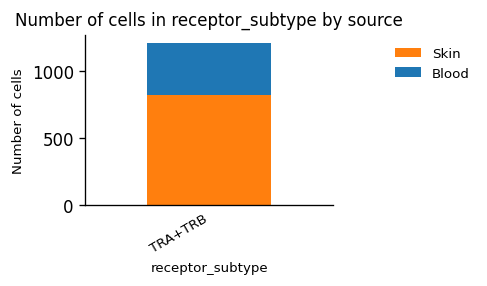

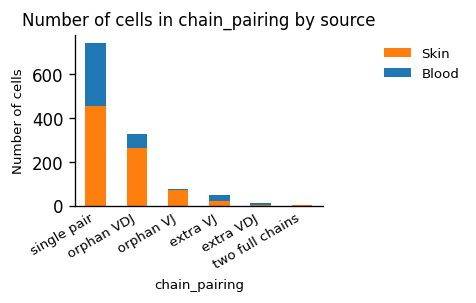

In [79]:
ax = ir.pl.group_abundance(tcells, groupby="receptor_subtype", target_col="source")
ax.figure.savefig("figures/Stacked_barplot_receptor_subtype_by_source.pdf")
ax = ir.pl.group_abundance(tcells, groupby="chain_pairing", target_col="source")
ax.figure.savefig("figures/Stacked_barplot_chain_paining_by_source.pdf")

In [80]:
# using default parameters, `ir_dist` will compute nucleotide sequence identity
ir.pp.ir_dist(tcells)
ir.tl.define_clonotypes(tcells, receptor_arms="all", dual_ir="primary_only")

Computing sequence x sequence distance matrix for VJ sequences.
Computing sequence x sequence distance matrix for VDJ sequences.
Initializing lookup tables. 
Computing clonotype x clonotype distances.


  0%|          | 0/758 [00:00<?, ?it/s]

Stored clonal assignments in `adata.obs["clone_id"]`.


In [81]:
ir.tl.clonotype_network(tcells, min_cells=2)

... storing 'clone_id' as categorical


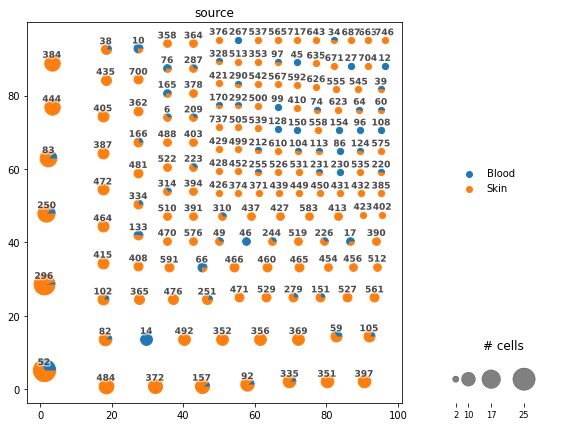

In [82]:
ax = ir.pl.clonotype_network(
    tcells, color="source", base_size=20, label_fontsize=9, panel_size=(7, 7)
)
ax.figure.savefig("figures/Clonotype_network.pdf")

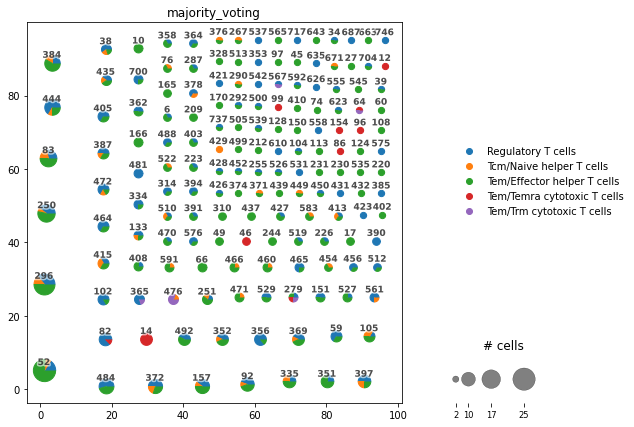

In [83]:
ax= ir.pl.clonotype_network(
    tcells, color="majority_voting", base_size=20, label_fontsize=9, panel_size=(7, 7)
)
ax.figure.savefig("figures/Clonotype_network_celltype.pdf")

In [84]:
#Re-compute CDR3 neighborhood graph and define clonotype clusters
ir.pp.ir_dist(
    tcells,
    metric="alignment",
    sequence="aa",
    cutoff=15,
)

Computing sequence x sequence distance matrix for VJ sequences.


  0%|          | 0/78 [00:00<?, ?it/s]

Computing sequence x sequence distance matrix for VDJ sequences.


  0%|          | 0/91 [00:00<?, ?it/s]

In [85]:
ir.tl.define_clonotype_clusters(
    tcells, sequence="aa", metric="alignment", receptor_arms="all", dual_ir="any"
)

Initializing lookup tables. 
Computing clonotype x clonotype distances.


  0%|          | 0/770 [00:00<?, ?it/s]

Stored clonal assignments in `adata.obs["cc_aa_alignment"]`.


In [87]:
ir.tl.clonotype_network(tcells, min_cells=3, sequence="aa", metric="alignment")

... storing 'cc_aa_alignment' as categorical


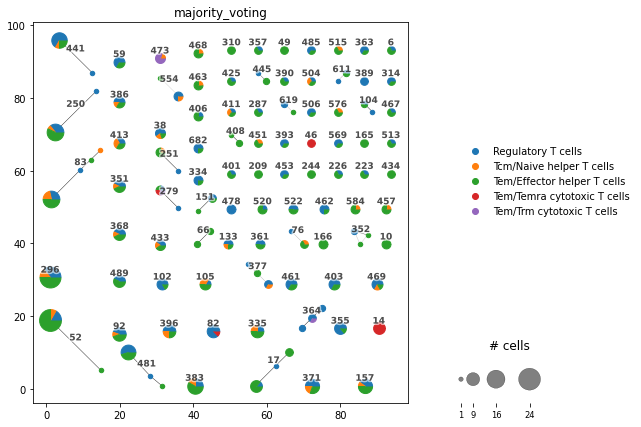

In [89]:
ax = ir.pl.clonotype_network(
    tcells, color="majority_voting", label_fontsize=9, panel_size=(7, 7), base_size=20
)
ax.figure.savefig("figures/Clonotype_network_aa_celltype.pdf")

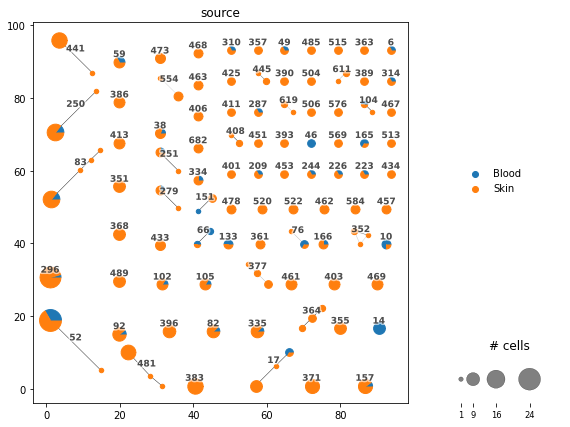

In [90]:
ax = ir.pl.clonotype_network(
    tcells, color="source", label_fontsize=9, panel_size=(7, 7), base_size=20
)
ax.figure.savefig("figures/Clonotype_network_aa_source.pdf")

In [91]:
#extract information (e.g. CDR3-sequences) from a specific clonotype cluster by subsetting AnnData
tcells.obs.loc[tcells.obs["cc_aa_alignment"] == "83", :].groupby(
    [
        "IR_VJ_1_junction_aa",
        "IR_VJ_2_junction_aa",
        "IR_VDJ_1_junction_aa",
        "IR_VDJ_2_junction_aa",
        "receptor_subtype",
    ],
    observed=True,
).size().reset_index(name="n_cells")

,IR_VJ_1_junction_aa,IR_VJ_2_junction_aa,IR_VDJ_1_junction_aa,IR_VDJ_2_junction_aa,receptor_subtype,n_cells
0,CILRYKAAGNKLTF,CAVSDQDNQGGKLIF,CASSYGYNEKLFF,CASSLDGRGWETQYF,TRA+TRB,1


... storing 'clonal_expansion' as categorical


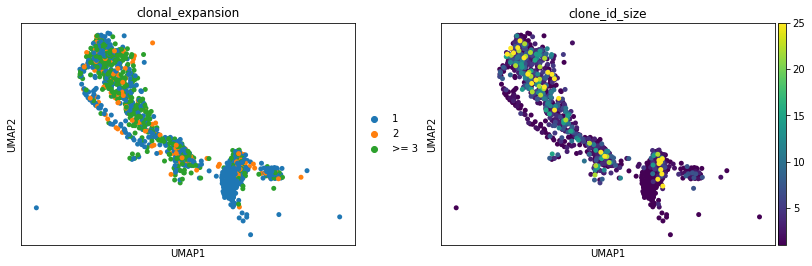

In [92]:
#clonal expansion: i.e. clonotypes consisting of more than one cell
ir.tl.clonal_expansion(tcells)
sc.pl.umap(tcells, color=["clonal_expansion", "clone_id_size"], save = "_clonal_expansion_Adata_tcells_merged.pdf")

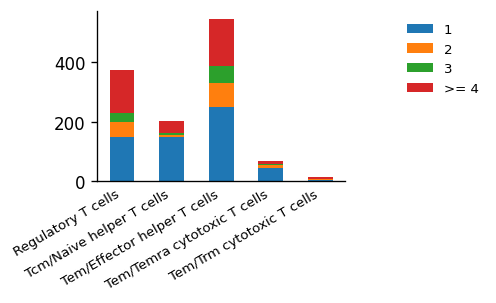

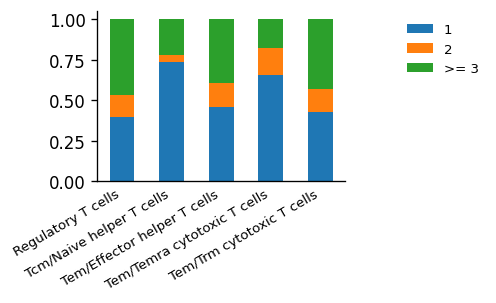

In [93]:
ax = ir.pl.clonal_expansion(tcells, groupby="majority_voting", clip_at=4, normalize=False)
ax.figure.savefig("figures/Clonal_expansion_celltype.pdf")
ax2 = ir.pl.clonal_expansion(tcells, "majority_voting")
ax2.figure.savefig("figures/Clonal_expansion_celltype_normalized.pdf")

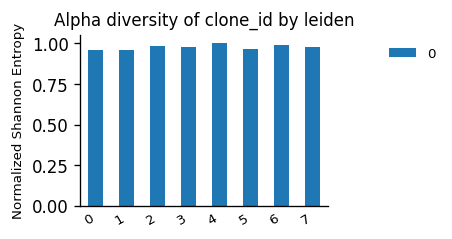

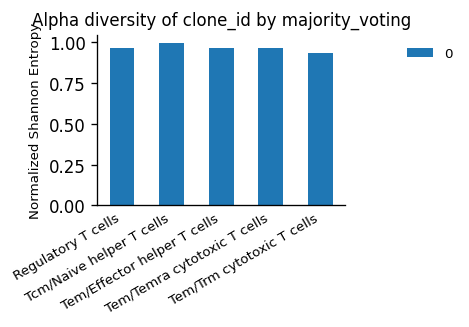

In [97]:
ax = ir.pl.alpha_diversity(
    tcells, metric="normalized_shannon_entropy", groupby="leiden"
)
ax.figure.savefig("figures/Alpha_diversity_by_leiden.pdf")
ax2 = ir.pl.alpha_diversity(
    tcells, metric="normalized_shannon_entropy", groupby="majority_voting"
)
ax2.figure.savefig("figures/Alpha_diversity_by_leiden.pdf")

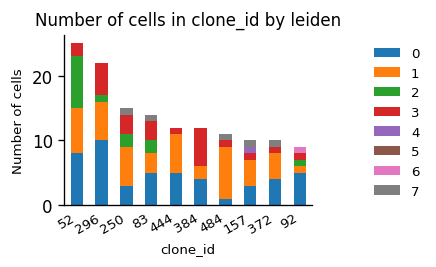

In [98]:
#Clonotype abundance
ax = ir.pl.group_abundance(tcells, groupby="clone_id", target_col="leiden", max_cols=10)
ax.figure.savefig("figures/Clonotype_abundance.pdf")

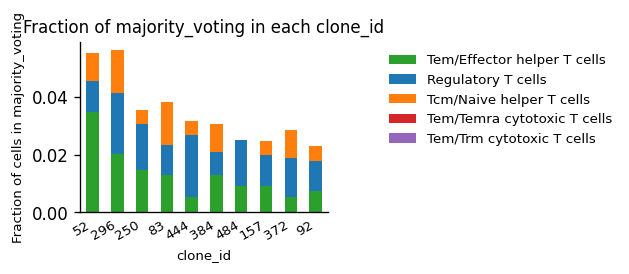

In [99]:
ax = ir.pl.group_abundance(
    tcells, groupby="clone_id", target_col="majority_voting", max_cols=10, normalize="majority_voting"
)
ax.figure.savefig("figures/Clonotype_abundance_by_cellytype.pdf")

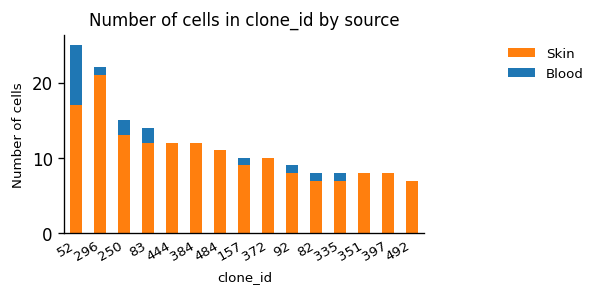

In [100]:
ax = ir.pl.group_abundance(
    tcells, groupby="clone_id", target_col="source", max_cols=15, figsize=(5, 3)
)
ax.figure.savefig("figures/Clonotype_abundance_by_sample.pdf")

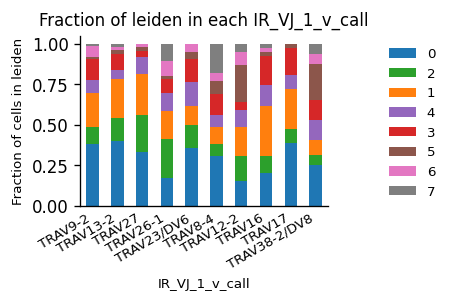

In [101]:
#Gene usage
ax = ir.pl.group_abundance(
    tcells, groupby="IR_VJ_1_v_call", target_col="leiden", normalize=True, max_cols=10
)
ax.figure.savefig("figures/Gene_usage.pdf")

Trying to set attribute `.uns` of view, copying.


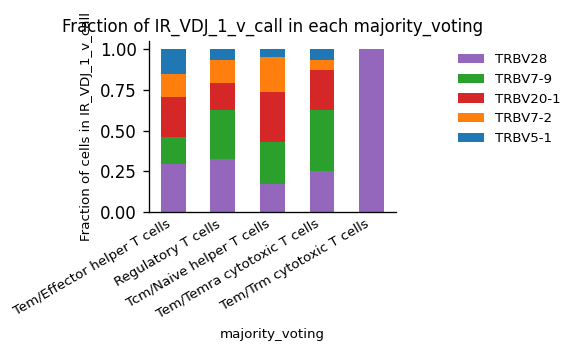

In [102]:
ax = ir.pl.group_abundance(
    tcells[
        tcells.obs["IR_VDJ_1_v_call"].isin(
            ["TRBV20-1", "TRBV7-2", "TRBV28", "TRBV5-1", "TRBV7-9"]
        ),
        :,
    ],
    groupby="majority_voting",
    target_col="IR_VDJ_1_v_call",
    normalize=True,
)
ax.figure.savefig("figures/Gene_usage_by_celltype.pdf")

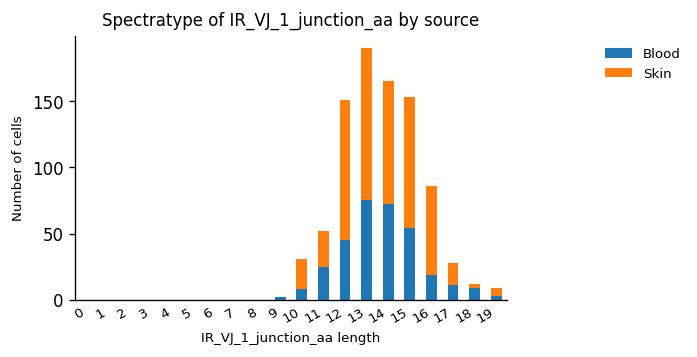

In [103]:
ax = ir.pl.spectratype(tcells, color="source", viztype="bar", fig_kws={"dpi": 120})
ax.figure.savefig("figures/Spectratype.pdf")

In [104]:
#Comparing repertoires
df, dst, lk = ir.tl.repertoire_overlap(tcells, "source", inplace=False)
df.head()

clone_id,0,1,2,3,4,5,6,7,8,9,...,748,749,750,751,752,753,754,755,756,757
source,,,,,,,,,,,,,,,,,,,,,
Blood,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Skin,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [105]:
#Comparing repertoires
df, dst, lk = ir.tl.repertoire_overlap(tcells, "majority_voting", inplace=False)
df.head()

clone_id,0,1,2,3,4,5,6,7,8,9,...,748,749,750,751,752,753,754,755,756,757
majority_voting,,,,,,,,,,,,,,,,,,,,,
Regulatory T cells,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
Tcm/Naive helper T cells,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Tem/Effector helper T cells,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0
Tem/Temra cytotoxic T cells,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Tem/Trm cytotoxic T cells,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


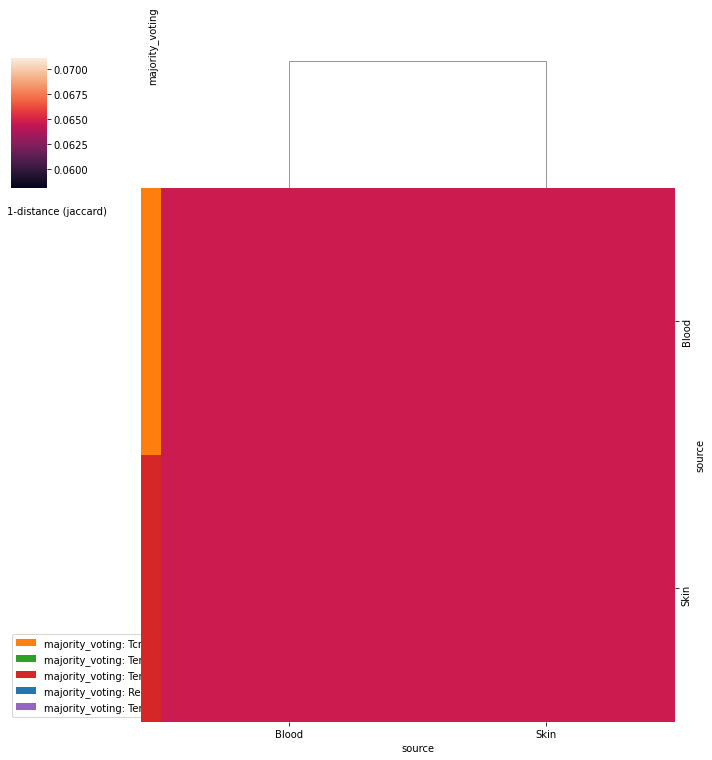

In [106]:
#Jaccard index distance matrix
ax = ir.pl.repertoire_overlap(tcells, "source", heatmap_cats=["majority_voting"])
ax.savefig("figures/Jaccard_heatmap.pdf")

No handles with labels found to put in legend.


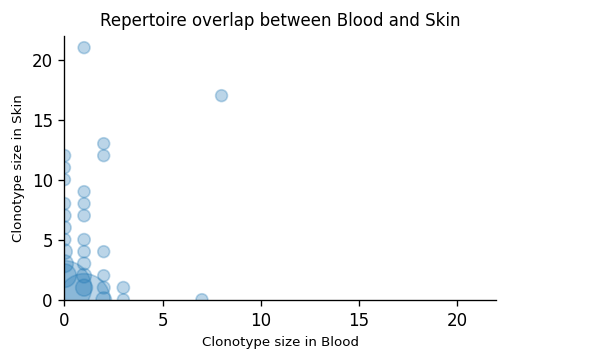

In [107]:
ax = ir.pl.repertoire_overlap(
    tcells, "sample", pair_to_plot=["Blood", "Skin"], fig_kws={"dpi": 120}
)
ax.figure.savefig("figures/Overlap.pdf")

In [108]:
#clonotype modularity
ir.tl.clonotype_modularity(tcells)

Initalizing clonotype subgraphs...


  0%|          | 0/758 [00:00<?, ?it/s]

Computing background distributions...


  0%|          | 0/1000 [00:00<?, ?it/s]

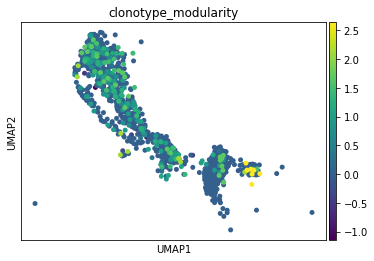

In [109]:
sc.pl.umap(tcells, color="clonotype_modularity", save = "_clonotype_modularity")

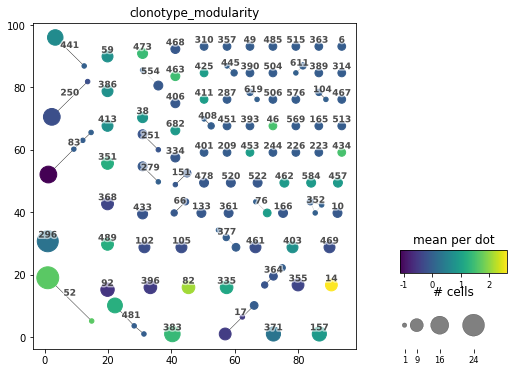

In [110]:
ax = ir.pl.clonotype_network(
    tcells,
    color="clonotype_modularity",
    label_fontsize=9,
    panel_size=(6, 6),
    base_size=20,
)
ax.figure.savefig("figures/Network_clonotype_modularity.pdf")

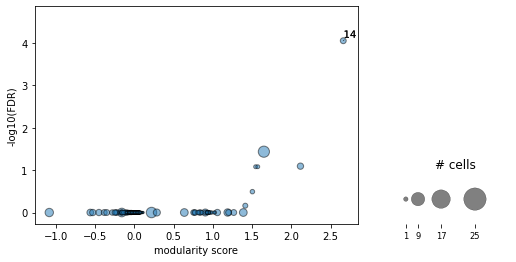

In [111]:
ax = ir.pl.clonotype_modularity(tcells, base_size=20)
ax.figure.savefig("figures/Clonotype_modulartiy_clone_id_score.pdf")

In [116]:
clonotypes_top_modularity = list(
    tcells.obs.set_index("cc_aa_alignment")["clonotype_modularity"]
    .sort_values(ascending=False)
    .index.unique()
    .values[:1]
)

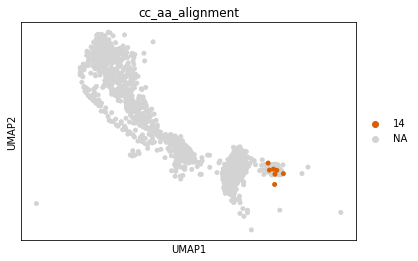

In [119]:
sc.pl.umap(
    tcells,
    color="cc_aa_alignment",
    groups=clonotypes_top_modularity,
    palette=cycler(color=mpl_cm.Dark2_r.colors),
    save = "Clonotype_14_modularity.pdf")

ranking genes
    finished (0:00:00)


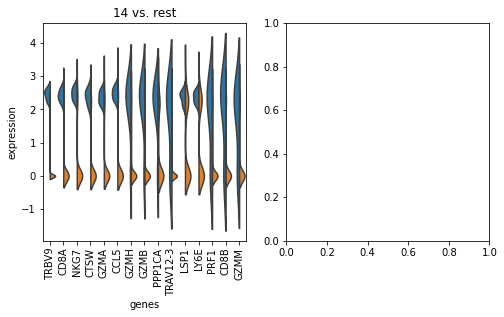

In [121]:
sc.tl.rank_genes_groups(
    tcells,
    "clone_id",
    groups=clonotypes_top_modularity,
    reference="rest",
    method="wilcoxon",
)
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
for ct, ax in zip(clonotypes_top_modularity, axs):
    sc.pl.rank_genes_groups_violin(
        tcells, groups=[ct], n_genes=15, ax=ax, show=False, strip=False
    )

In [123]:
#Clonotype imbalance
freq, stat = ir.tl.clonotype_imbalance(
    tcells,
    replicate_col="source",
    groupby="majority_voting",
    case_label="Tcm/Naive helper T cells",
    control_label="Tem/Effector helper T cells",
    inplace=False,
)
top_differential_clonotypes = stat["clone_id"].tolist()[:3]

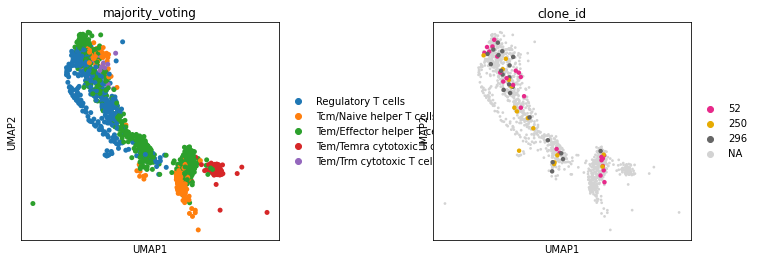

In [128]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw={"wspace": 0.6})
sc.pl.umap(tcells, color="majority_voting", ax=ax1, show=False)
sc.pl.umap(
    tcells,
    color="clone_id",
    groups=top_differential_clonotypes,
    ax=ax2,
    # increase size of highlighted dots
    size=[
        80 if c in top_differential_clonotypes else 30 for c in tcells.obs["clone_id"]
    ],
    palette=cycler(color=mpl_cm.Dark2_r.colors),
    save = "Clonotype_imbalance_Tcm_vs_Tem.pdf"
)

No handles with labels found to put in legend.


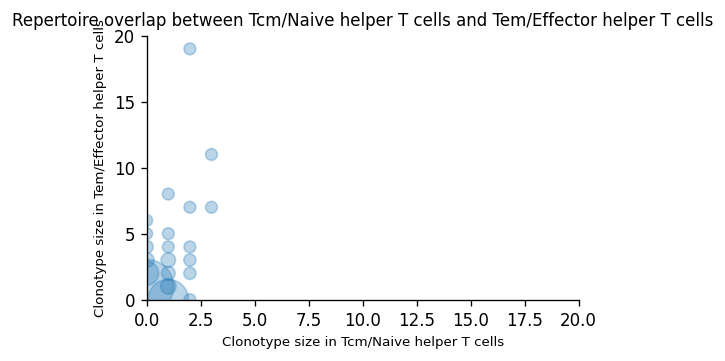

In [132]:
ax = ir.tl.repertoire_overlap(tcells, "majority_voting")
ax = ir.pl.repertoire_overlap(
    tcells, "majority_voting", pair_to_plot=["Tcm/Naive helper T cells", "Tem/Effector helper T cells"], fig_kws={"dpi": 120}
)
ax.figure.savefig("figures/Repertoire_overlap_Tcm_vs_Tm.pdf")

ranking genes
    finished (0:00:00)


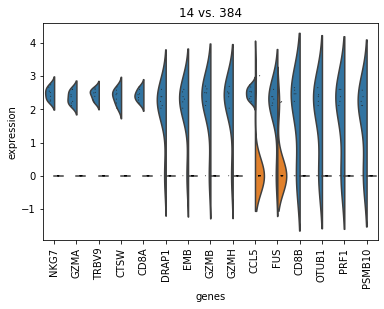

In [133]:
#Marker genes in top clonotypes
sc.tl.rank_genes_groups(
    tcells, "clone_id", groups=["14"], reference="384", method="wilcoxon"
)
sc.pl.rank_genes_groups_violin(tcells, groups="14", n_genes=15)

In [134]:
#Epitope prediction
vdjdb = ir.datasets.vdjdb()

In [135]:
ir.pp.ir_dist(tcells, vdjdb, metric="identity", sequence="aa")

Computing sequence x sequence distance matrix for VJ sequences.
Computing sequence x sequence distance matrix for VDJ sequences.


In [136]:
ir.tl.ir_query(
    tcells, vdjdb, metric="identity", sequence="aa", receptor_arms="any", dual_ir="any"
)

Initializing lookup tables. 
Computing clonotype x clonotype distances.


  0%|          | 0/770 [00:00<?, ?it/s]

Stored IR distance matrix in `adata.uns["ir_query_VDJDB_aa_identity"]`.


In [137]:
ax = ir.tl.ir_query_annotate_df(
    tcells,
    vdjdb,
    metric="identity",
    sequence="aa",
    include_ref_cols=["antigen.species", "antigen.gene"],
)

ax.to_csv('figures/Epitope_table.csv')

ir.tl.ir_query_annotate_df(
    tcells,
    vdjdb,
    metric="identity",
    sequence="aa",
    include_ref_cols=["antigen.species", "antigen.gene"],
).tail()

,antigen.species,antigen.gene
TTTGCGCGTCGCGGTT-1_1,InfluenzaA,M
TTTGCGCGTCGCGGTT-1_1,EBV,EBNA4
TTTGCGCGTCGCGGTT-1_1,CMV,IE1
TTTGCGCGTCGCGGTT-1_1,EBV,EBNA4
TTTGCGCGTCGCGGTT-1_1,CMV,IE1


In [140]:
ir.tl.ir_query_annotate(
    tcells,
    vdjdb,
    metric="identity",
    sequence="aa",
    include_ref_cols=["antigen.species"],
    strategy="most-frequent",
)

  0%|          | 0/144 [00:00<?, ?it/s]

ValueError: columns overlap but no suffix specified: Index(['antigen.species'], dtype='object')

... storing 'antigen.species' as categorical


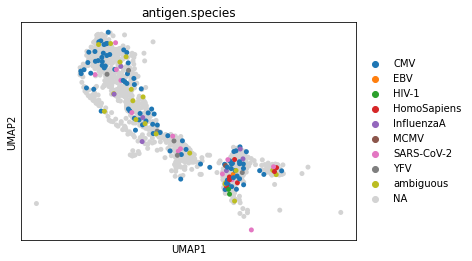

In [141]:
sc.pl.umap(tcells, color="antigen.species", save = "_Merged_epitope.pdf")

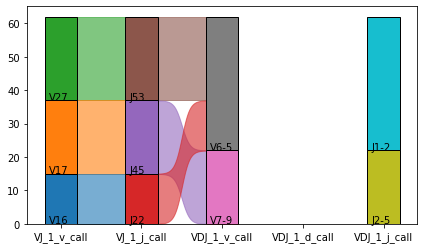

In [154]:
#EXTRAS

#VDJ genes combinations
ax = ir.pl.vdj_usage(tcells[tcells.obs["clone_id"].isin(["52", "296", "250"]), :], full_combination=False, max_segments=None, max_ribbons=30)
ax.figure.savefig("figures/VDJ_genes_combi_top3_clones_highest_cellnumber.pdf")

<AxesSubplot:>

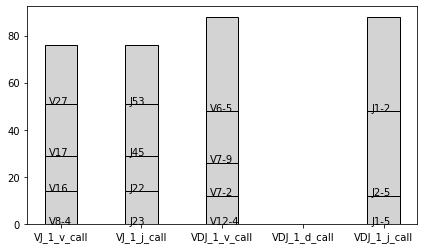

In [144]:
#VDJ usage of certain clonotypes of interest
ir.pl.vdj_usage(
    tcells[tcells.obs["clone_id"].isin(["52", "296", "250", "83", "444"]), :],
    max_ribbons=None,
    max_segments=100,
)

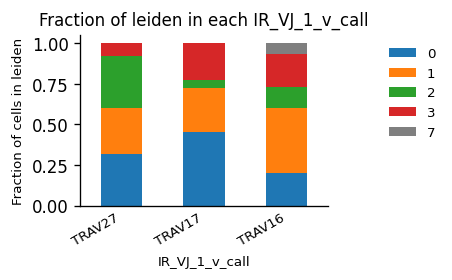

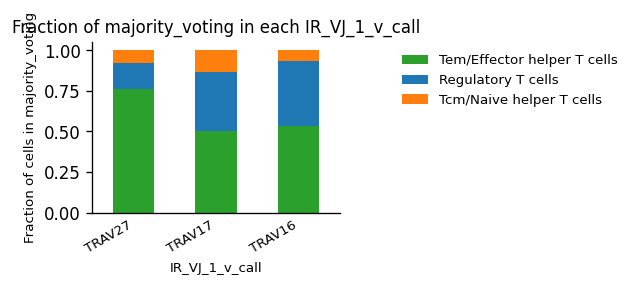

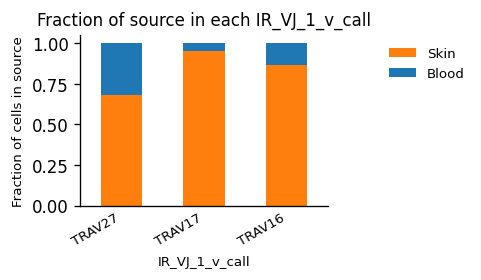

In [151]:
ax = ir.pl.group_abundance(
    tcells[tcells.obs["clone_id"].isin(["52", "296", "250"]), :], groupby="IR_VJ_1_v_call", target_col="leiden", normalize=True, max_cols=10
)
ax.figure.savefig("figures/Fraction_VDJ_top5_clones_by_leiden.pdf")
ax = ir.pl.group_abundance(
    tcells[tcells.obs["clone_id"].isin(["52", "296", "250"]), :], groupby="IR_VJ_1_v_call", target_col="majority_voting", normalize=True, max_cols=10
)
ax.figure.savefig("figures/Fraction_VDJ_top5_clones_by_celltype.pdf")
ax = ir.pl.group_abundance(
    tcells[tcells.obs["clone_id"].isin(["52", "296", "250"]), :], groupby="IR_VJ_1_v_call", target_col="source", normalize=True, max_cols=10
)
ax.figure.savefig("figures/Fraction_VDJ_top5_clones_by_source.pdf")

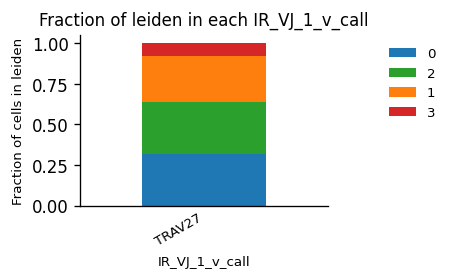

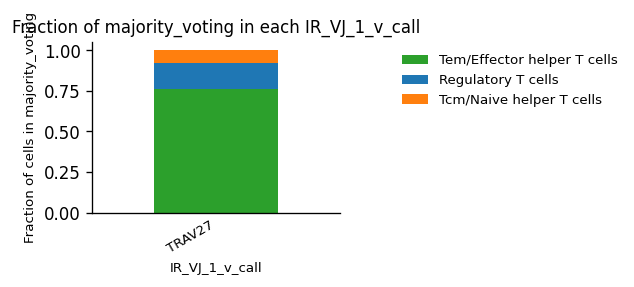

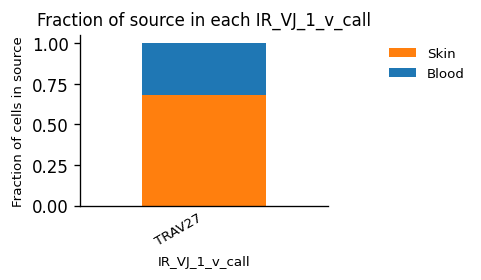

In [152]:
#Top 3 clones seperately:52
ax = ir.pl.group_abundance(
    tcells[tcells.obs["clone_id"].isin(["52"]), :], groupby="IR_VJ_1_v_call", target_col="leiden", normalize=True, max_cols=10
)
ax.figure.savefig("figures/Fraction_VDJ_52_clones_by_leiden.pdf")
ax = ir.pl.group_abundance(
    tcells[tcells.obs["clone_id"].isin(["52"]), :], groupby="IR_VJ_1_v_call", target_col="majority_voting", normalize=True, max_cols=10
)
ax.figure.savefig("figures/Fraction_VDJ_52_clones_by_celltype.pdf")
ax = ir.pl.group_abundance(
    tcells[tcells.obs["clone_id"].isin(["52"]), :], groupby="IR_VJ_1_v_call", target_col="source", normalize=True, max_cols=10
)
ax.figure.savefig("figures/Fraction_VDJ_52_clones_by_source.pdf")

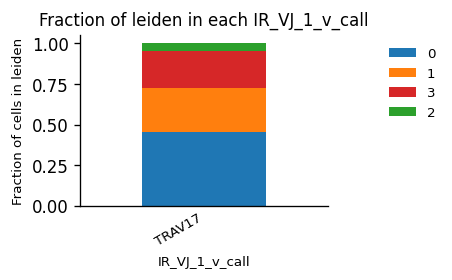

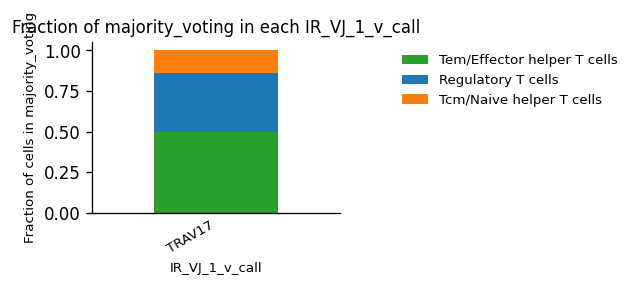

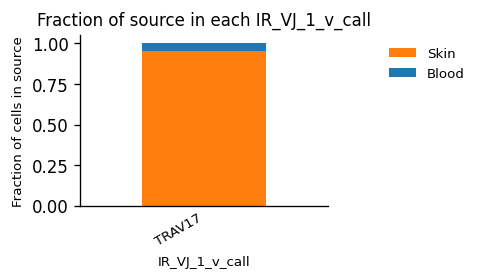

In [153]:
#Top 3 clones seperately:296
ax = ir.pl.group_abundance(
    tcells[tcells.obs["clone_id"].isin(["296"]), :], groupby="IR_VJ_1_v_call", target_col="leiden", normalize=True, max_cols=10
)
ax.figure.savefig("figures/Fraction_VDJ_296_clones_by_leiden.pdf")
ax = ir.pl.group_abundance(
    tcells[tcells.obs["clone_id"].isin(["296"]), :], groupby="IR_VJ_1_v_call", target_col="majority_voting", normalize=True, max_cols=10
)
ax.figure.savefig("figures/Fraction_VDJ_296_clones_by_celltype.pdf")
ax = ir.pl.group_abundance(
    tcells[tcells.obs["clone_id"].isin(["296"]), :], groupby="IR_VJ_1_v_call", target_col="source", normalize=True, max_cols=10
)
ax.figure.savefig("figures/Fraction_VDJ_296_clones_by_source.pdf")

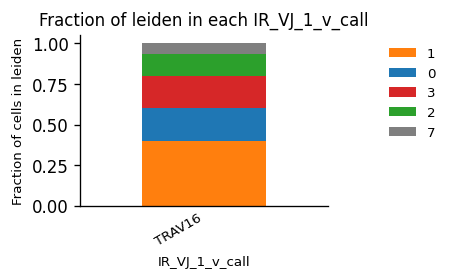

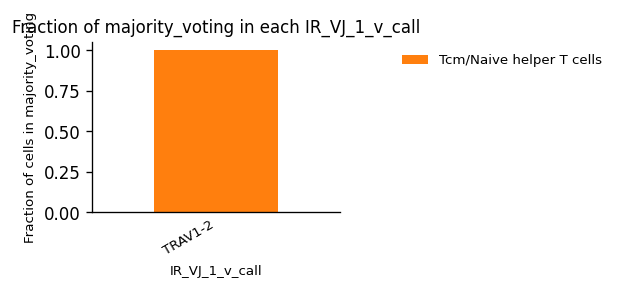

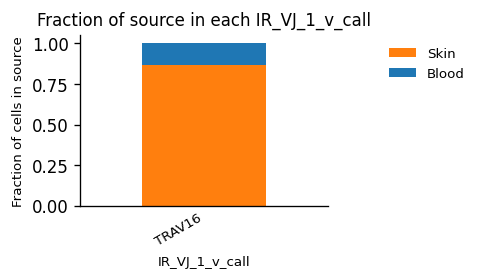

In [155]:
#Top 3 clones seperately
ax = ir.pl.group_abundance(
    tcells[tcells.obs["clone_id"].isin(["250"]), :], groupby="IR_VJ_1_v_call", target_col="leiden", normalize=True, max_cols=10
)
ax.figure.savefig("figures/Fraction_VDJ_250_clones_by_leiden.pdf")
ax = ir.pl.group_abundance(
    tcells[tcells.obs["clone_id"].isin(["259"]), :], groupby="IR_VJ_1_v_call", target_col="majority_voting", normalize=True, max_cols=10
)
ax.figure.savefig("figures/Fraction_VDJ_250_clones_by_celltype.pdf")
ax = ir.pl.group_abundance(
    tcells[tcells.obs["clone_id"].isin(["250"]), :], groupby="IR_VJ_1_v_call", target_col="source", normalize=True, max_cols=10
)
ax.figure.savefig("figures/Fraction_VDJ_250_clones_by_source.pdf")

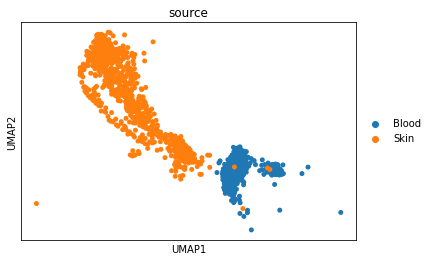

In [158]:
#UMAP only tcells showing where skin and blood are located
sc.pl.umap(tcells, color="source", save = "_only_tcells_by_source.pdf")

In [177]:
#Cell numbers of skin and blood
#tcells[tcells.obs["source"].isin(["Skin"]) == True] #817 out of 1205
#tcells[tcells.obs["source"].isin(["Blood"]) == True] #388 out of 1205

#Clone numbers by source
#tcells.obs.loc[tcells.obs["source"] == "Blood", :].groupby(["clone_id"],observed=True,).size()  #457 out of 757
#tcells.obs.loc[tcells.obs["source"] == "Blood", :].groupby( ["clone_id"],observed=True,).size()  #350 out of 757